#### Auto Encoder

This is the auto encoder implementation that is going to be used in our study, the 

In [23]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub # Gather data from kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [24]:
# Loading dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
file = os.path.join(path, "creditcard.csv")
df = pd.read_csv(file)
 
print(df.shape)

(284807, 31)


In [ ]:
# Data split (organization of training and test data)
x = df.drop(columns=['Class'])  # Extracts all features except target
y = df['Class']  # Extracts only the target feature

# Split dataset into 80% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=15,
                                                    stratify=y)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Check class distribution in training and testing sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Testing set class distribution:\n", y_test.value_counts(normalize=True))

Training set class distribution:
 Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64
Testing set class distribution:
 Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


In [26]:
# Auto Encoder model
input_dimension = x_train_scaled.shape[1]
print(input_dimension)
hidden_layer = 15
input_layer = Input(shape=(input_dimension,))
Encoder = Dense(hidden_layer,activation="relu")(input_layer)
Decoder = Dense(input_dimension,activation="sigmoid")(Encoder)
autoencoder_model = Model(inputs=input_layer,outputs=Decoder)

30


In [27]:
# Compile model
optimizer = Adam(learning_rate=0.001)
autoencoder_model.compile(optimizer=optimizer, loss='mse')

In [28]:
autoencoder_model.fit(x_train_scaled, x_train_scaled, epochs=50, batch_size=512, validation_data=(x_test_scaled, x_test_scaled))

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0201 - val_loss: 0.0037
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.8075e-04 - val_loss: 0.0011
Epoch 8/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.4636e-04 - val_loss: 9.8811e-04
Epoch 9/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.3500e-04 - val_loss: 8.9106e-04
Epoch 10/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.5263e-04 - val_loss: 8.2003e-04
Epoch 11/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.8940e-04 - val_loss: 7.7436e-04
Epoch 12/50
445

In [30]:
encoder_model = Model(inputs=autoencoder_model.input, outputs=Encoder)

In [32]:
encoded_x_train = encoder_model.predict(x_train_scaled)
encoded_x_test = encoder_model.predict(x_test_scaled)

6231/6231 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [33]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(encoded_x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Predict on test data
predictions = knn.predict(encoded_x_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, digits=4))

Accuracy: 0.9991807403766253
              precision    recall  f1-score   support

           0     0.9992    0.9999    0.9996     85295
           1     0.9432    0.5608    0.7034       148

    accuracy                         0.9992     85443
   macro avg     0.9712    0.7804    0.8515     85443
weighted avg     0.9991    0.9992    0.9991     85443



In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

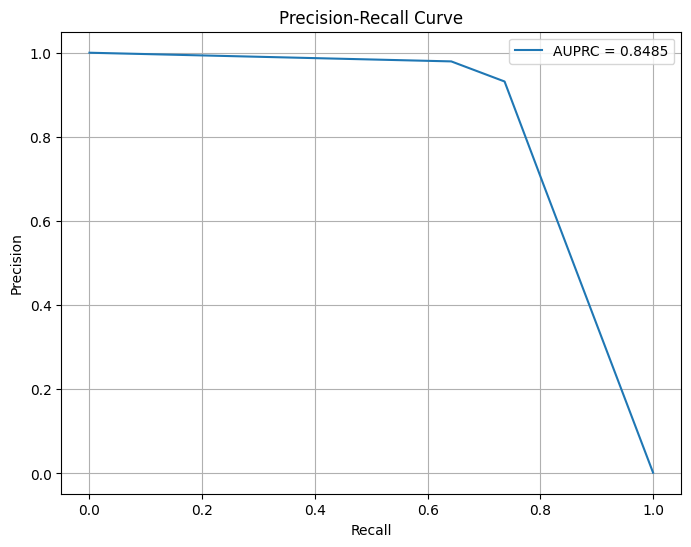

In [22]:
# Get precision-recall values
precision, recall, _ = precision_recall_curve(y_test, knn.predict_proba(encoded_x_test)[:, 1])

# Compute AUPRC
auprc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AUPRC = {auprc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()